In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, SubsetRandomSampler
import torch.nn as nn
from torchvision import datasets
import numpy as np
from PIL import Image
from pytorch_model_summary import summary
from torchvision.datasets.folder import pil_loader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

C:\Users\user\anaconda3\envs\my-torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
item = 'Retina'

In [3]:
import os
cwd = os.getcwd()
path = os.path.join(cwd, 'data')
path = os.path.join(path, 'Retina_OCT')
path = os.path.join(path, 'train')
path = os.path.join(path, 'NORMAL')
#path = os.path.join(path, 'good')
#filename = os.path.join(path, '000.png')




In [4]:
img_h = 224
img_w = 224
# Wide-ResNet preprocessing
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize((img_h,img_w)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
class MyDataset(Dataset):
    def __init__(self, image_ids, image_dir, transform, target_transform=None):
        self.image_ids = image_ids
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        image = pil_loader(os.path.join(self.image_dir, self.image_ids[index]))

        if self.transform:
            image = self.transform(image)

        x, y = image, image
        return x, y

    def __len__(self):
        return len(self.image_ids)



In [6]:
dataset = MyDataset(os.listdir(path), path, preprocess)
batch_size = 16
validation_split = .5
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                                sampler=valid_sampler)

In [7]:
print(len(dataset))
print(len(train_loader.sampler))
print(len(validation_loader.sampler))


26315
13158
13157


In [8]:

class CustomResNet(nn.Module):
    def __init__(self, model):
        super(CustomResNet, self).__init__()

        self.l1 = nn.Sequential(model.conv1,
                                model.bn1,
                                model.relu,
                                model.maxpool,
                                model.layer1)
        self.l2 = nn.Sequential(
                                model.layer2)
        self.l3 = nn.Sequential(
                                model.layer3)
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.l2(x1)
        x3 = self.l3(x2)
        return x1, x2, x3


In [9]:
from typing import Callable, List, Optional, Type, Union

import torch
from torch import Tensor, nn
from torchvision.models.resnet import BasicBlock, Bottleneck


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding."""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class OCBE(nn.Module):
    """One-Class Bottleneck Embedding module.
    Args:
        block (Bottleneck): Expansion value is extracted from this block.
        layers (int): Numbers of OCE layers to create after multiscale feature fusion.
        groups (int, optional): Number of blocked connections from input channels to output channels.
            Defaults to 1.
        width_per_group (int, optional): Number of layers in each intermediate convolution layer. Defaults to 64.
        norm_layer (Optional[Callable[..., nn.Module]], optional): Batch norm layer to use. Defaults to None.
    """

    def __init__(
        self,
        block: Type[Union[Bottleneck, BasicBlock]],
        layers: int,
        groups: int = 1,
        width_per_group: int = 64,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.groups = groups
        self.base_width = width_per_group
        self.inplanes = 256 * block.expansion
        self.dilation = 1
        self.bn_layer = self._make_layer(block, 512, layers, stride=2)

        self.conv1 = conv3x3(64 * block.expansion, 128 * block.expansion, 2)
        self.bn1 = norm_layer(128 * block.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(128 * block.expansion, 256 * block.expansion, 2)
        self.bn2 = norm_layer(256 * block.expansion)
        self.conv3 = conv3x3(128 * block.expansion, 256 * block.expansion, 2)
        self.bn3 = norm_layer(256 * block.expansion)

        # This is present in the paper but not in the original code. With some initial experiments, removing this leads
        # to better results
        # self.conv4 = conv1x1(256 * block.expansion * 3, 256 * block.expansion * 3, 1)  # x3 as we concatenate 3 layers
        # self.bn4 = norm_layer(256 * block.expansion * 3)

        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(module, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

    def _make_layer(
        self,
        block: Type[Union[Bottleneck, BasicBlock]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes * 3, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes * 3,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, features: List[Tensor]) -> Tensor:
        """Forward-pass of Bottleneck layer.
        Args:
            features (List[Tensor]): List of features extracted from the encoder.
        Returns:
            Tensor: Output of the bottleneck layer
        """
        # Always assumes that features has length of 3
        feature0 = self.relu(self.bn2(self.conv2(self.relu(self.bn1(self.conv1(features[0]))))))
        feature1 = self.relu(self.bn3(self.conv3(features[1])))
        feature_cat = torch.cat([feature0, feature1, features[2]], 1)
        output = self.bn_layer(feature_cat)
        #output = self.bn_layer(self.bn4(self.conv4(feature_cat)))

        return output.contiguous()

In [10]:
from typing import Any, Callable, List, Optional, Type, Union, Tuple

from torch import Tensor, nn
from torchvision.models.resnet import conv1x1, conv3x3

class DecoderBasicBlock(nn.Module):
    """Basic block for decoder ResNet architecture.
    Args:
        inplanes (int): Number of input channels.
        planes (int): Number of output channels.
        stride (int, optional): Stride for convolution and de-convolution layers. Defaults to 1.
        upsample (Optional[nn.Module], optional): Module used for upsampling output. Defaults to None.
        groups (int, optional): Number of blocked connections from input channels to output channels.
            Defaults to 1.
        base_width (int, optional): Number of layers in each intermediate convolution layer. Defaults to 64.
        dilation (int, optional): Spacing between kernel elements. Defaults to 1.
        norm_layer (Optional[Callable[..., nn.Module]], optional): Batch norm layer to use.Defaults to None.
    Raises:
        ValueError: If groups are not equal to 1 and base width is not 64.
        NotImplementedError: If dilation is greater than 1.
    """

    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        upsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 2
        if stride == 2:
            self.conv1 = nn.ConvTranspose2d(
                inplanes, planes, kernel_size=2, stride=stride, groups=groups, bias=False, dilation=dilation
            )
        else:
            self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.upsample = upsample
        self.stride = stride

    def forward(self, batch: Tensor) -> Tensor:
        """Forward-pass of de-resnet block."""
        identity = batch

        out = self.conv1(batch)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample is not None:
            identity = self.upsample(batch)

        out += identity
        out = self.relu(out)

        return out


class DecoderBottleneck(nn.Module):
    """Bottleneck for Decoder.
    Args:
        inplanes (int): Number of input channels.
        planes (int): Number of output channels.
        stride (int, optional): Stride for convolution and de-convolution layers. Defaults to 1.
        upsample (Optional[nn.Module], optional): Module used for upsampling output. Defaults to None.
        groups (int, optional): Number of blocked connections from input channels to output channels.
            Defaults to 1.
        base_width (int, optional): Number of layers in each intermediate convolution layer. Defaults to 64.
        dilation (int, optional): Spacing between kernel elements. Defaults to 1.
        norm_layer (Optional[Callable[..., nn.Module]], optional): Batch norm layer to use.Defaults to None.
    """

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        upsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 2
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        if stride == 2:
            self.conv2 = nn.ConvTranspose2d(
                width, width, kernel_size=2, stride=stride, groups=groups, bias=False, dilation=dilation
            )
        else:
            self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.upsample = upsample
        self.stride = stride

    def forward(self, batch: Tensor) -> Tensor:
        """Forward-pass of de-resnet bottleneck block."""
        identity = batch

        out = self.conv1(batch)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.upsample is not None:
            identity = self.upsample(batch)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    """ResNet model for decoder.
    Args:
        block (Type[Union[DecoderBasicBlock, DecoderBottleneck]]): Type of block to use in a layer.
        layers (List[int]): List to specify number for blocks per layer.
        zero_init_residual (bool, optional): If true, initializes the last batch norm in each layer to zero.
            Defaults to False.
        groups (int, optional): Number of blocked connections per layer from input channels to output channels.
            Defaults to 1.
        width_per_group (int, optional): Number of layers in each intermediate convolution layer.. Defaults to 64.
        norm_layer (Optional[Callable[..., nn.Module]], optional): Batch norm layer to use. Defaults to None.
    """

    def __init__(
        self,
        block: Type[Union[DecoderBasicBlock, DecoderBottleneck]],
        layers: List[int],
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 512 * block.expansion
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        self.layer1 = self._make_layer(block, 256, layers[0], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)

        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(module, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for module in self.modules():
                if isinstance(module, DecoderBottleneck):
                    nn.init.constant_(module.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(module, DecoderBasicBlock):
                    nn.init.constant_(module.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[DecoderBasicBlock, DecoderBottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        upsample = None
        previous_dilation = self.dilation
        if stride != 1 or self.inplanes != planes * block.expansion:
            upsample = nn.Sequential(
                nn.ConvTranspose2d(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=2,
                    stride=stride,
                    groups=self.groups,
                    bias=False,
                    dilation=self.dilation,
                ),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(self.inplanes, planes, stride, upsample, self.groups, self.base_width, previous_dilation, norm_layer)
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, batch: Tensor) -> List[Tensor]:
        """Forward pass for Decoder ResNet. Returns list of features."""
        feature_a = self.layer1(batch)  # 512*8*8->256*16*16
        feature_b = self.layer2(feature_a)  # 256*16*16->128*32*32
        feature_c = self.layer3(feature_b)  # 128*32*32->64*64*64

        return [feature_c, feature_b, feature_a]

def _resnet(block: Type[Union[DecoderBasicBlock, DecoderBottleneck]], layers: List[int], **kwargs: Any) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    return model

def de_wide_resnet50_2() -> ResNet:
    """Wide ResNet-50-2 model."""
    return _resnet(DecoderBottleneck, [3, 4, 6, 3], width_per_group=128)

In [11]:
#Testing components generation:
from pytorch_model_summary import summary
# load WRN-50-2:
full_w_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
#encoder-architecture
enc = CustomResNet(model=full_w_resnet)
for param in enc.parameters():
    param.requires_grad = False
print(summary(enc, torch.zeros((1, 3, img_h, img_w))))

Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.10.0


-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 64, 112, 112]           9,408               0
     BatchNorm2d-2     [1, 64, 112, 112]             128               0
            ReLU-3     [1, 64, 112, 112]               0               0
       MaxPool2d-4       [1, 64, 56, 56]               0               0
      Bottleneck-5      [1, 256, 56, 56]         206,336               0
      Bottleneck-6      [1, 256, 56, 56]         214,016               0
      Bottleneck-7      [1, 256, 56, 56]         214,016               0
      Bottleneck-8      [1, 512, 28, 28]         920,576               0
      Bottleneck-9      [1, 512, 28, 28]         854,016               0
     Bottleneck-10      [1, 512, 28, 28]         854,016               0
     Bottleneck-11      [1, 512, 28, 28]         854,016               0
     Bottleneck-12     [1, 1024, 14, 14]       3,6

In [16]:
ocbe = OCBE(Bottleneck, 3)
print(summary(ocbe, enc(torch.zeros((1, 3, img_h, img_w)))))

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1      [1, 512, 28, 28]       1,179,648       1,179,648
     BatchNorm2d-2      [1, 512, 28, 28]           1,024           1,024
            ReLU-3      [1, 512, 28, 28]               0               0
          Conv2d-4     [1, 1024, 14, 14]       4,718,592       4,718,592
     BatchNorm2d-5     [1, 1024, 14, 14]           2,048           2,048
            ReLU-6     [1, 1024, 14, 14]               0               0
          Conv2d-7     [1, 1024, 14, 14]       4,718,592       4,718,592
     BatchNorm2d-8     [1, 1024, 14, 14]           2,048           2,048
            ReLU-9     [1, 1024, 14, 14]               0               0
     Bottleneck-10       [1, 2048, 7, 7]      11,282,432      11,282,432
     Bottleneck-11       [1, 2048, 7, 7]       4,462,592       4,462,592
     Bottleneck-12       [1, 2048, 7, 7]       4,4

In [18]:
decoder = de_wide_resnet50_2()
print(summary(decoder, ocbe(enc(torch.zeros((1, 3, img_h, img_w))))))

------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
    DecoderBottleneck-1     [1, 1024, 14, 14]      11,016,192      11,016,192
    DecoderBottleneck-2     [1, 1024, 14, 14]       3,411,968       3,411,968
    DecoderBottleneck-3     [1, 1024, 14, 14]       3,411,968       3,411,968
    DecoderBottleneck-4      [1, 512, 28, 28]       2,755,584       2,755,584
    DecoderBottleneck-5      [1, 512, 28, 28]         854,016         854,016
    DecoderBottleneck-6      [1, 512, 28, 28]         854,016         854,016
    DecoderBottleneck-7      [1, 512, 28, 28]         854,016         854,016
    DecoderBottleneck-8      [1, 256, 56, 56]         689,664         689,664
    DecoderBottleneck-9      [1, 256, 56, 56]         214,016         214,016
   DecoderBottleneck-10      [1, 256, 56, 56]         214,016         214,016
   DecoderBottleneck-11      [1, 256, 56, 56]         214,016  

In [11]:
from typing import List, Tuple, Union

import torch
import torch.nn.functional as F
from kornia.filters import gaussian_blur2d
from torch import Tensor


class AnomalyMapGenerator:
    """Generate Anomaly Heatmap.
    Args:
        image_size (Union[ListConfig, Tuple]): Size of original image used for upscaling the anomaly map.
        sigma (int): Standard deviation of the gaussian kernel used to smooth anomaly map.
        mode (str, optional): Operation used to generate anomaly map. Options are `add` and `multiply`.
                Defaults to "multiply".
    Raises:
        ValueError: In case modes other than multiply and add are passed.
    """

    def __init__(self, image_size: Tuple, sigma: int = 4, mode: str = "multiply"):
        self.image_size = image_size
        self.sigma = sigma
        self.kernel_size = 2 * int(4.0 * sigma + 0.5) + 1

        if mode not in ("add", "multiply"):
            raise ValueError(f"Found mode {mode}. Only multiply and add are supported.")
        self.mode = mode

    def __call__(self, student_features: List[Tensor], teacher_features: List[Tensor]) -> Tensor:
        """Computes anomaly map given encoder and decoder features.
        Args:
            student_features (List[Tensor]): List of encoder features
            teacher_features (List[Tensor]): List of decoder features
        Returns:
            Tensor: Anomaly maps of length batch.
        """
        if self.mode == "multiply":
            anomaly_map = torch.ones(
                [student_features[0].shape[0], 1, *self.image_size], device=student_features[0].device
            )  # b c h w
        elif self.mode == "add":
            anomaly_map = torch.zeros(
                [student_features[0].shape[0], 1, *self.image_size], device=student_features[0].device
            )

        for student_feature, teacher_feature in zip(student_features, teacher_features):
            distance_map = 1 - F.cosine_similarity(student_feature, teacher_feature)
            distance_map = torch.unsqueeze(distance_map, dim=1)
            distance_map = F.interpolate(distance_map, size=self.image_size, mode="bilinear", align_corners=True)
            if self.mode == "multiply":
                anomaly_map *= distance_map
            elif self.mode == "add":
                anomaly_map += distance_map

        anomaly_map = gaussian_blur2d(
            anomaly_map, kernel_size=(self.kernel_size, self.kernel_size), sigma=(self.sigma, self.sigma)
        )

        return anomaly_map

In [12]:
from typing import Any, Callable, List, Optional, Type, Union
class ReverseDistillationModel(nn.Module):
    """Reverse Distillation Model.
    Args:
        backbone (str): Name of the backbone used for encoder and decoder
        input_size (Tuple[int, int]): Size of input image
        layers (List[str]): Name of layers from which the features are extracted.
        anomaly_map_mode (str): Mode used to generate anomaly map. Options are between ``multiply`` and ``add``.
    """

    def __init__(self, encoder, oceb, decoder, input_size = (224, 224), anomaly_map_mode: str = 'multiply'):
        super().__init__()

        for param in encoder.parameters():
            param.requires_grad = False
        self.encoder = encoder
        self.oceb = oceb
        self.decoder = decoder

        image_size = input_size

        self.anomaly_map_generator = AnomalyMapGenerator(image_size=tuple(image_size), mode=anomaly_map_mode)

    def forward(self, images: Tensor) -> Union[Tensor, Tuple[List[Tensor], List[Tensor]]]:
        """Forward-pass images to the network.
        During the training mode the model extracts features from encoder and decoder networks.
        During evaluation mode, it returns the predicted anomaly map.
        Args:
            images (Tensor): Batch of images
        Returns:
            Union[Tensor, Tuple[List[Tensor],List[Tensor]]]: Encoder and decoder features in training mode,
                else anomaly maps.
        """
        self.encoder.eval()

        encoder_features = self.encoder(images)
        #encoder_features = list(encoder_features.values())

        decoder_features = self.decoder(self.oceb(encoder_features))

        if self.training:
            output = encoder_features, decoder_features
        else:
            output = self.anomaly_map_generator(encoder_features, decoder_features)

        return output

In [13]:
full_w_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
torch.cuda.empty_cache()
model = ReverseDistillationModel(encoder=CustomResNet(model=full_w_resnet),
                                 oceb=OCBE(Bottleneck, 3),
                                 decoder=de_wide_resnet50_2()).to(device)

print(summary(model, torch.zeros((1, 3, img_h, img_w)).to(device)))

Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.10.0


-------------------------------------------------------------------------------------------------------------
      Layer (type)                                              Output Shape         Param #     Tr. Param #
    CustomResNet-1     [1, 256, 56, 56], [1, 512, 28, 28], [1, 1024, 14, 14]      24,862,528               0
            OCBE-2                                           [1, 2048, 7, 7]      30,829,568      30,829,568
          ResNet-3     [1, 256, 56, 56], [1, 512, 28, 28], [1, 1024, 14, 14]      24,917,504      24,917,504
Total params: 80,609,600
Trainable params: 55,747,072
Non-trainable params: 24,862,528
-------------------------------------------------------------------------------------------------------------


In [ ]:
import hiddenlayer as hl

hl_graph = hl.build_graph(model, torch.zeros((1, 3, img_h, img_w)).to('cuda'))
hl_graph.theme = hl.graph.THEMES["blue"].copy()
#hl_graph.save(path="model" , format="jpg")
hl_graph

In [14]:

def kd_loss(encoder_features: List[Tensor], decoder_features: List[Tensor]) -> Tensor:
    """Computes cosine similarity loss based on features from encoder and decoder.
    Args:
    encoder_features (List[Tensor]): List of features extracted from encoder
    decoder_features (List[Tensor]): List of features extracted from decoder
    Returns:
    Tensor: Cosine similarity loss
    """
    cos_loss = torch.nn.CosineSimilarity()
    losses = list(map(cos_loss, encoder_features, decoder_features))
    loss_sum = 0
    for loss in losses:
        loss_sum += torch.mean(1 - loss)  # mean of cosine distance
    return loss_sum




In [23]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 3         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    5620 MB |    5757 MB |     930 GB |     925 GB |
|       from large pool |    5570 MB |    5707 MB |     928 GB |     922 GB |
|       from small pool |      50 MB |      68 MB |       2 GB |       2 GB |
|---------------------------------------------------------------------------|
| Active memory         |    5620 MB |    5757 MB |     930 GB |     925 GB |
|       from large pool |    5570 MB |    5707 MB |     928 GB |

In [ ]:
from tqdm import trange
from time import sleep

# Model Initialization
torch.cuda.empty_cache()

# Using an Adam Optimizer with lr = 0.01
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr = 0.005,
                             betas=(0.5, 0.999))


epochs = 200
outputs = []
losses = []

t = trange(range(epochs)[-1], desc="Epoch num %i")

#for epoch in range(epochs):
for epoch in t:
    t.set_description("Epoch num: %i" % epoch)
    t.refresh() # to show immediately the update
    sleep(0.01)
    for (image, _) in train_loader:

        image =  image.to(device)
        # Output of Teacher
        encoded = model.encoder(image)
        #Output of Student
        reconstructed = model.decoder(model.oceb(encoded))
        # Calculating the loss function
        loss = kd_loss(encoded, reconstructed)

        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #outputs.append((epochs, image, reconstructed))
        torch.cuda.empty_cache()
    # Storing the losses in a list for plotting
    losses.append(loss)

Epoch num: 65:  33%|███▎      | 65/199 [4:06:17<8:31:47, 229.16s/it] 

In [ ]:
import datetime
time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
import matplotlib.pyplot as plt
cpu_losses = []
for loss in losses:
    cpu_losses.append(loss.to('cpu').detach().numpy())
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
# Plotting the last 100 values
plt.plot(cpu_losses)
plt.savefig('{1}_Training_{0}.png'.format(time, item))





In [ ]:
save_path =  os.path.join(cwd, "SavedModels")
save_path =  os.path.join(save_path, '{1}_SavedModel{0}.pt'.format(time, item))
torch.save(model.state_dict(),save_path)

In [ ]:
save_path =  os.path.join(cwd, "SavedModels")
model_path = os.path.join(save_path, '{1}_SavedModel{0}.pt'.format(time, item))
model = ReverseDistillationModel(encoder=CustomResNet(model=full_w_resnet),
                                 oceb=OCBE(Bottleneck, 3),
                                 decoder=de_wide_resnet50_2())
model.load_state_dict(torch.load(model_path))
model.eval()



In [25]:
torch.cuda.empty_cache()

In [29]:
from PIL import Image
image = Image.new('RGB', (224, 224), (0, 0, 0))
image.save(os.path.join(cwd, "good_mask.png"), "PNG")

In [ ]:
image_list = list()
gt_list = list()
path = os.path.join(cwd, "data")
path = os.path.join(path, "Retina_OCT")

test_path = os.path.join(path, "test")
test_dirs = os.listdir(test_path)
for test_dir in test_dirs:
    cur_dir = os.path.join(test_path, test_dir)

    for i, file in enumerate(os.listdir(cur_dir)):
        image_list.append(os.path.join(cur_dir, file))
        if "NORMAL" in cur_dir:
            gt_list.append(0)
        else:
            gt_list.append(1)

In [ ]:
class MyTestDataset(Dataset):
    def __init__(self, image_paths, ground_truth_paths, transform, target_transform=None, img_w = 224, img_h = 224):
        self.image_paths = image_paths
        self.ground_truth_paths = ground_truth_paths
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        image = pil_loader(self.image_paths[index])
        gt = pil_loader(self.ground_truth_paths[index])
        gt = gt.resize((img_w, img_h), Image.NEAREST)
        gt = gt.convert('L')
        gt = np.asarray(gt)
        gt = gt[None, :]
        if self.transform:
            image = self.transform(image)

        x, y = image, gt
        return x, y

    def __len__(self):
        return len(self.image_paths)

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((img_h,img_w)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = MyTestDataset(image_list, gt_list, preprocess)
batch_size = 1
validation_split = 1
shuffle_dataset = False
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=valid_sampler)
print(len(dataset))
print(len(test_loader.sampler))

In [ ]:
#Compute AUROC
from sklearn.metrics import roc_curve, auc # roc curve tools
an_maps = list()
gts = list()
for (image, gt) in test_loader:
    an_map = model.to("cpu").forward(image)

    gts.append(gt)
    #for an_px in an_map.detach():
    #print(torch.max(an_map.detach()))
    an_maps.append(torch.max(an_map.detach()))

print(len(an_maps))
print(len(gts))


In [93]:
#Compute AUROC
#Here we are thresholding the LOSS instead of the anomaly detection score of RKD
from sklearn.metrics import roc_curve, auc # roc curve tools
an_maps = list()
gts = list()
for (image, gt) in test_loader:
    encoded = model.encoder(image)
    #Output of Student
    reconstructed = model.decoder(model.oceb(encoded))
    # Calculating the loss function
    loss = kd_loss(encoded, reconstructed)
    gts.append(gt)
    #for an_px in an_map.detach():
    #print(torch.max(an_map.detach()))
    an_maps.append(loss.detach())

print(len(an_maps))
print(len(gts))

for (image, _) in validation_loader:
    encoded = model.encoder(image)
    #Output of Student
    reconstructed = model.decoder(model.oceb(encoded))
    # Calculating the loss function
    loss = kd_loss(encoded, reconstructed)
    gts.append(0)
    an_maps.append(loss.detach())

print(len(an_maps))
print(len(gts))

155
155
179
179


In [94]:
gts =  np.asarray(gts).astype(int)
fpr, tpr, thresholds = roc_curve(gts,an_maps)
roc_auc = auc(fpr,tpr)
#Compute  Youden’s J statistic wrt each threshold and sort results in decreasing order
optimal_proba_cutoff = sorted(list(zip(np.abs(tpr - fpr), thresholds)), key=lambda i: i[0], reverse=True)
print("Threshold sorted values are:", optimal_proba_cutoff[0])

Threshold sorted values are: (0.6983870967741935, 0.38628393)


C:\Users\user\AppData\Local\Temp\ipykernel_15768\3506520834.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gts =  np.asarray(gts).astype(int)
C:\Users\user\AppData\Local\Temp\ipykernel_15768\3506520834.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gts =  np.asarray(gts).astype(int)


Threshold optimal cutoff value is: 0.38628393


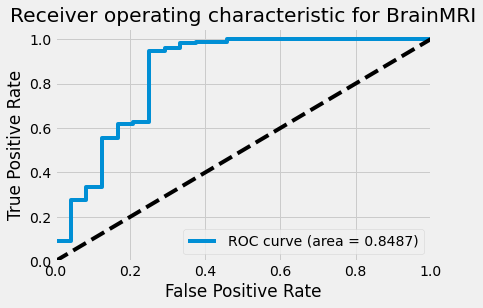

In [97]:


import matplotlib.pyplot as plt
#Plot AUROC and print best threshold
fig, ax = plt.subplots(1,1)
optimal_threshold = optimal_proba_cutoff[0][-1]#find_optimal_cutoff(fpr, tpr, thresholds)
print("Threshold optimal cutoff value is:", optimal_threshold)

ax.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic for {0}'.format(item))
ax.legend(loc="lower right")
fig.savefig(os.path.join(cwd, "ROC_{0}.png".format(item)))

In [26]:
#To calculate the per-region overlap, real-valued anomaly scores are thresholded to obtain a
# binary prediction for each pixel in the test set.
# Then, the percentage of correctly predicted pixels is computed for each annotated defect region
# in the ground-truth.
# The average over all defects yields the final PRO value.
#https://link.springer.com/article/10.1007/s11263-022-01578-9
def compute_pro(anomaly_map, ground_truth, threshold = 0.01):
    binary_class = list()
    correct_predicted = 0
    anomaly_region = 0
    for px in anomaly_map:
        #print("Anomaly map pixel: " + str(px))
        if px >= threshold:
            binary_class.append(1)
        else:
            binary_class.append(0)
    for i, px in enumerate(ground_truth):
        #print("GT pixel: "+ str(px))

        if px == 1:
            anomaly_region +=1
            if binary_class[i] == 1:
                correct_predicted += 1



    pro = correct_predicted/anomaly_region
    print("Correct predicted pixels: " + str(correct_predicted))
    print("Anomaly region pixels: " + str(anomaly_region))
    print("Predicted anomaly pixels: " + str(binary_class.count(1)))
    return pro

In [62]:
#Compute PRO
pro = compute_pro(an_maps, gts, optimal_threshold)
print(pro)

Correct predicted pixels: 286406
Anomaly region pixels: 413063
Predicted anomaly pixels: 1243491
0.69337122908612


In [67]:
image = pil_loader("data/BrainMRIImagesForBrainTumorDetection/no/N1.JPG")
image = preprocess(image)
image = image[None, :]
anomaly_map = model.to('cpu').forward(image)

im = torch.swapaxes(image[0], 0, -1)
im = torch.swapaxes(im, 0, 1)
an_map = torch.swapaxes(anomaly_map[0], 0, -1)
an_map = torch.swapaxes(an_map, 0, 1)


print(im.shape)
print(an_map.shape)

torch.Size([224, 224, 3])
torch.Size([224, 224, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


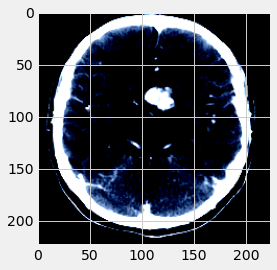

In [68]:
plt.imshow(im)

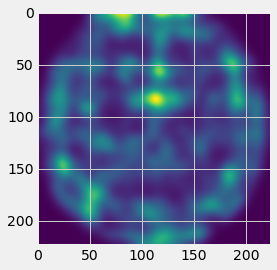

In [69]:
plt.imshow(an_map.detach().numpy())

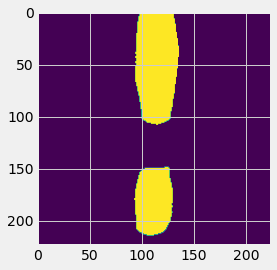

In [31]:
gt = pil_loader("data/mvtec_AD/zipper/ground_truth/combined/000_mask.png")
preprocess2 = transforms.Compose([
    #transforms.Resize((img_h,img_w)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485], std=[0.229]),
])

gt = gt.resize((img_w, img_h), Image.NEAREST)
gt = preprocess2(gt)
gt = torch.swapaxes(gt[0], 0, -1)
gt = torch.swapaxes(gt, 0, 1)
plt.imshow(gt)



In [38]:
import pandas as pd
def find_optimal_cutoff(fpr, tpr, threshold):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------
    list type, with optimal cutoff value

    """
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])


